In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, string
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('Preprocessed Fake Reviews Detection Dataset.csv')
df.head()

,Unnamed: 0,category,rating,label,text_
0,0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort love pretti
1,1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin mine coupl year
2,2,Home_and_Kitchen_5,5.0,CG,pillow save back love look feel pillow
3,3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price
4,4,Home_and_Kitchen_5,5.0,CG,nice set good qualiti set two month


In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort love pretti
1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin mine coupl year
2,Home_and_Kitchen_5,5.0,CG,pillow save back love look feel pillow
3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price
4,Home_and_Kitchen_5,5.0,CG,nice set good qualiti set two month


In [6]:
df.dropna(inplace=True)

In [7]:
df['length'] = df['text_'].apply(len)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40431 entries, 0 to 40431
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40431 non-null  object 
 1   rating    40431 non-null  float64
 2   label     40431 non-null  object 
 3   text_     40431 non-null  object 
 4   length    40431 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB


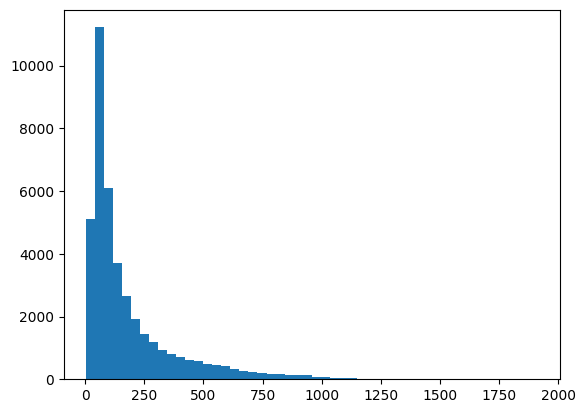

In [9]:
plt.hist(df['length'],bins=50)
plt.show()

In [10]:
df.groupby('label').describe()

rating                                                length  \
         count      mean       std  min  25%  50%  75%  max    count   
label                                                                  
CG     20215.0  4.259906  1.141092  1.0  4.0  5.0  5.0  5.0  20215.0   
OR     20216.0  4.253265  1.147652  1.0  4.0  5.0  5.0  5.0  20216.0   

                                                                
             mean         std  min   25%    50%    75%     max  
label                                                           
CG     149.864259  150.769467  4.0  50.0   86.0  186.0  1191.0  
OR     214.748269  229.518418  6.0  66.0  120.0  267.0  1911.0

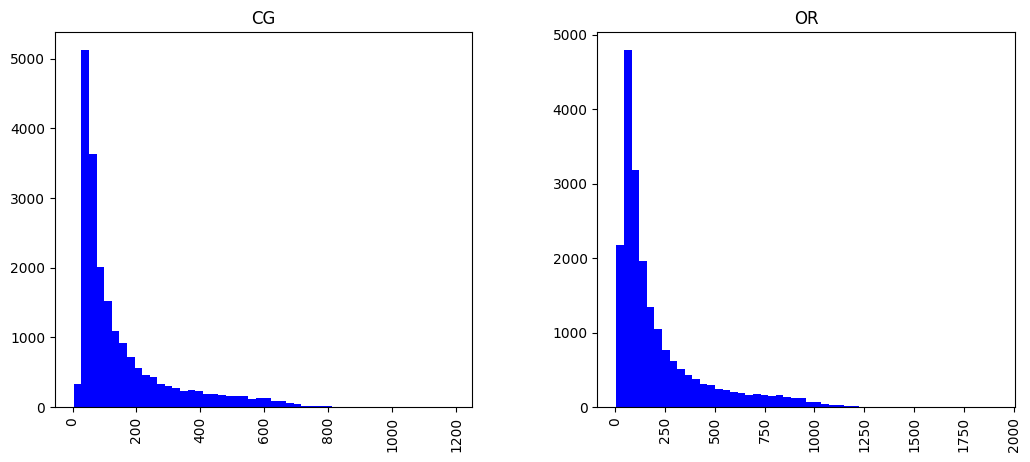

In [11]:
df.hist(column='length',by='label',bins=50,color='blue',figsize=(12,5))
plt.show()

Let's extract the largest review...

In [12]:
df[df['label']=='OR'][['text_','length']].sort_values(by='length',ascending=False).head().iloc[0].text_

'thought purchas item also nbsp data hook product link link class link normal href kidco door knob lock clear pack dp b0010cd2io ref cm_cr_arp_d_rvw_txt ie utf8 kidco door knob lock clear pack nbsp nbsp data hook product link link class link normal href door knob lock dp b00238meqa ref cm_cr_arp_d_rvw_txt ie utf8 door knob lock white color nbsp data hook product link link class link normal href kidco door knob lock color white dp b001j2wjf2 ref cm_cr_arp_d_rvw_txt ie utf8 kidco door knob lock color white nbsp nbsp data hook product link link class link normal href door knob lock pack dp b00069bvgm ref cm_cr_arp_d_rvw_txt ie utf8 door knob lock pack nbsp data hook product link link class link normal href secur grip clear door knob cover pack dp b00068xbxe ref cm_cr_arp_d_rvw_txt ie utf8 secur grip clear door knob cover pack nbsp compar two overal function well although coupl disadvantag overcom hack advantag easi put two halv togeth match tab slot hing cover lock unlik safeti 1st open a

In [13]:
df.length.describe()

count    40431.000000
mean       182.307066
std        196.868016
min          4.000000
25%         56.000000
50%        102.000000
75%        224.000000
max       1911.000000
Name: length, dtype: float64

In [14]:
def text_process(review):
    nopunc = [char for char in review if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [15]:
bow_transformer = CountVectorizer(analyzer=text_process)
bow_transformer

CountVectorizer(analyzer=<function text_process at 0x0000017169C18540>)

In [16]:
bow_transformer.fit(df['text_'])
print("Total Vocabulary:",len(bow_transformer.vocabulary_))

Total Vocabulary: 27641


In [ ]:
review4 = df['text_'][3]
review4

'miss inform use great product price'

In [17]:
bow_msg4 = bow_transformer.transform([review4])
print(bow_msg4)
print(bow_msg4.shape)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (1, 27641)>
  Coords	Values
  (0, 10901)	1
  (0, 12631)	1
  (0, 15992)	1
  (0, 19107)	1
  (0, 19207)	1
  (0, 25911)	1
(1, 27641)


There are 6 unique words in the 4th review.

In [18]:
feature_names = bow_transformer.get_feature_names_out()
print(feature_names[15841])
print(feature_names[23848])

millennium
swan


In [19]:
bow_reviews = bow_transformer.transform(df['text_'])

In [20]:
print("Shape of Bag of Words Transformer for the entire reviews corpus:",bow_reviews.shape)
print("Amount of non zero values in the bag of words model:",bow_reviews.nnz)

Shape of Bag of Words Transformer for the entire reviews corpus: (40431, 27641)
Amount of non zero values in the bag of words model: 986109


In [21]:
print("Sparsity:",np.round((bow_reviews.nnz/(bow_reviews.shape[0]*bow_reviews.shape[1]))*100,2))

Sparsity: 0.09


In [22]:
tfidf_transformer = TfidfTransformer().fit(bow_reviews)
tfidf_rev4 = tfidf_transformer.transform(bow_msg4)
print(bow_msg4)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (1, 27641)>
  Coords	Values
  (0, 10901)	1
  (0, 12631)	1
  (0, 15992)	1
  (0, 19107)	1
  (0, 19207)	1
  (0, 25911)	1


In [23]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['mango']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['book']])

10.91422964906803
2.819393433430175


In [24]:
tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("Shape:",tfidf_reviews.shape)
print("No. of Dimensions:",tfidf_reviews.ndim)

Shape: (40431, 27641)
No. of Dimensions: 2


## Creating training and testing data

In [25]:
review_train, review_test, label_train, label_test = train_test_split(df['text_'],df['label'],test_size=0.35)

In [1]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

NameError: name 'Pipeline' is not defined

## Training and testing Multinomial Naive Bayes Algorithm on the preprocessed data

In [2]:
pipeline.fit(review_train,label_train)

NameError: name 'pipeline' is not defined

In [3]:
predictions = pipeline.predict(review_test)
predictions

NameError: name 'pipeline' is not defined

In [4]:
print('Classification Report:',classification_report(label_test,predictions))
print('Confusion Matrix:',confusion_matrix(label_test,predictions))
print('Accuracy Score:',accuracy_score(label_test,predictions))

NameError: name 'classification_report' is not defined

In [5]:
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,predictions)*100,2)) + '%')

NameError: name 'np' is not defined

In [6]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
])

NameError: name 'Pipeline' is not defined

In [7]:
pipeline.fit(review_train,label_train)

NameError: name 'pipeline' is not defined

In [8]:
rfc_pred = pipeline.predict(review_test)
rfc_pred

NameError: name 'pipeline' is not defined

In [9]:
print('Classification Report:',classification_report(label_test,rfc_pred))
print('Confusion Matrix:',confusion_matrix(label_test,rfc_pred))
print('Accuracy Score:',accuracy_score(label_test,rfc_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,rfc_pred)*100,2)) + '%')

NameError: name 'classification_report' is not defined

In [35]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',DecisionTreeClassifier())
])

In [36]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000002B8473F3D80>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', DecisionTreeClassifier())])

In [37]:
dtree_pred = pipeline.predict(review_test)
dtree_pred

array(['OR', 'CG', 'OR', ..., 'OR', 'CG', 'OR'], dtype=object)

In [38]:
print('Classification Report:',classification_report(label_test,dtree_pred))
print('Confusion Matrix:',confusion_matrix(label_test,dtree_pred))
print('Accuracy Score:',accuracy_score(label_test,dtree_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,dtree_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.74      0.75      0.75      7107
          OR       0.75      0.73      0.74      7044

    accuracy                           0.74     14151
   macro avg       0.74      0.74      0.74     14151
weighted avg       0.74      0.74      0.74     14151

Confusion Matrix: [[5361 1746]
 [1870 5174]]
Accuracy Score: 0.7444703554519115
Model Prediction Accuracy: 74.45%


In [39]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',KNeighborsClassifier(n_neighbors=2))
])

In [40]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000002B8473F3D80>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', KNeighborsClassifier(n_neighbors=2))])

In [41]:
knn_pred = pipeline.predict(review_test)
knn_pred

array(['CG', 'CG', 'CG', ..., 'CG', 'CG', 'CG'], dtype=object)

In [42]:
print('Classification Report:',classification_report(label_test,knn_pred))
print('Confusion Matrix:',confusion_matrix(label_test,knn_pred))
print('Accuracy Score:',accuracy_score(label_test,knn_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,knn_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.55      0.97      0.70      7107
          OR       0.87      0.19      0.31      7044

    accuracy                           0.58     14151
   macro avg       0.71      0.58      0.50     14151
weighted avg       0.71      0.58      0.50     14151

Confusion Matrix: [[6912  195]
 [5734 1310]]
Accuracy Score: 0.5810190092572963
Model Prediction Accuracy: 58.1%


In [43]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',SVC())
])

In [44]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000002B8473F3D80>)),
                ('tfidf', TfidfTransformer()), ('classifier', SVC())])

In [45]:
svc_pred = pipeline.predict(review_test)
svc_pred

array(['OR', 'OR', 'CG', ..., 'CG', 'CG', 'OR'], dtype=object)

In [46]:
print('Classification Report:',classification_report(label_test,svc_pred))
print('Confusion Matrix:',confusion_matrix(label_test,svc_pred))
print('Accuracy Score:',accuracy_score(label_test,svc_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,svc_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.89      0.87      0.88      7107
          OR       0.87      0.90      0.88      7044

    accuracy                           0.88     14151
   macro avg       0.88      0.88      0.88     14151
weighted avg       0.88      0.88      0.88     14151

Confusion Matrix: [[6176  931]
 [ 733 6311]]
Accuracy Score: 0.8824111370221186
Model Prediction Accuracy: 88.24%


In [47]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',LogisticRegression())
])

In [48]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000002B8473F3D80>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression())])

In [49]:
lr_pred = pipeline.predict(review_test)
lr_pred

array(['OR', 'OR', 'CG', ..., 'CG', 'CG', 'OR'], dtype=object)

In [50]:
print('Classification Report:',classification_report(label_test,lr_pred))
print('Confusion Matrix:',confusion_matrix(label_test,lr_pred))
print('Accuracy Score:',accuracy_score(label_test,lr_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,lr_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.87      0.85      0.86      7107
          OR       0.85      0.87      0.86      7044

    accuracy                           0.86     14151
   macro avg       0.86      0.86      0.86     14151
weighted avg       0.86      0.86      0.86     14151

Confusion Matrix: [[6049 1058]
 [ 895 6149]]
Accuracy Score: 0.8619885520457918
Model Prediction Accuracy: 86.2%


# Conclusion

In [51]:
print('Performance of various ML models:')
print('\n')
print('Logistic Regression Prediction Accuracy:',str(np.round(accuracy_score(label_test,lr_pred)*100,2)) + '%')
print('K Nearest Neighbors Prediction Accuracy:',str(np.round(accuracy_score(label_test,knn_pred)*100,2)) + '%')
print('Decision Tree Classifier Prediction Accuracy:',str(np.round(accuracy_score(label_test,dtree_pred)*100,2)) + '%')
print('Random Forests Classifier Prediction Accuracy:',str(np.round(accuracy_score(label_test,rfc_pred)*100,2)) + '%')
print('Support Vector Machines Prediction Accuracy:',str(np.round(accuracy_score(label_test,svc_pred)*100,2)) + '%')
print('Multinomial Naive Bayes Prediction Accuracy:',str(np.round(accuracy_score(label_test,predictions)*100,2)) + '%')

Performance of various ML models:


Logistic Regression Prediction Accuracy: 86.2%
K Nearest Neighbors Prediction Accuracy: 58.1%
Decision Tree Classifier Prediction Accuracy: 74.45%
Random Forests Classifier Prediction Accuracy: 83.81%
Support Vector Machines Prediction Accuracy: 88.24%
Multinomial Naive Bayes Prediction Accuracy: 83.7%
